# Breakdown of `process_spectrum`
Note: Currently, all values are hard coded for example purposes. Once this code is fully integrated, the values listed below will be provided by the user:
- `source`
- `min_wavnum`
- `max_wavenum`
- `beamsplitter`
- `cell_window`
- `detector`

## Helper Functions
The following functions are crutical to the execution of the program. However they are not directly involved in the processing of spectra.

### Imports

In [134]:
import math, sys
from decimal import Decimal
from radis import calc_spectrum
from warnings import catch_warnings
#NOTE for graphing
import numpy as np 
import matplotlib.pyplot as plt

### Error Message
Called in cases where the user input is not vaild

In [135]:
# function presents error and usage to user, then quits
def __error(error_text):
  print(error_text)
  print("  usage: python3 generate_spectra.py <source (t or g)> <min-wavenumber (cm^-1)>  <max-wavenumber (cm^-1)> <beamsplitter AR_ZnSe or AR_CaF2>" +\
    "<cell_window KBr or CaF2 or ZnSe> <detector MCT or InSb>")
  quit()

### Wave number to Wavelength Conversion

In [136]:
# convert wavenumber (cm^-1) to wavelength (nm) (10000000 / wavenumber)
def __convert_wavenum_wavelen(min_wavenum, max_wavenum):
  min_wavelen = math.floor(10000000 / max_wavenum)
  max_wavelen = math.ceil(10000000 / min_wavenum)
  return min_wavelen, max_wavelen

### File I/O Functions

In [137]:
def __loadData(inputFile):

    try:
        file = open(inputFile, 'r')

    # File not found
    except:
        print(f'File not found: {inputFile}')
        return

    data = {}

    for line in file:
        if "#" not in line:
            (key, val) = line.split()
            data[float(key)] = float(val)

    file.close()

    return data

def __exportData(data, fileName):

    # open file and start at the begining
    file = open(fileName, 'w')

    for key in data:
        line = f'{key} {data[key]}\n'
        file.write(line)
    
    file.close()
    
    return True

## Taking in User Input and Verifying it
This step of the process takes in the user input and makes sure what they entered is a value that our program can accept. If the user enters in an unusable parameter or too few paramters, an error message will appear and the program will be stopped.

Feel free to change the variables!

In [138]:
# check number of args
if len(sys.argv) < 7:
    __error("  not enought command line arguments")

# Change us!
source = 't'
min_wavenum = 400
max_wavenum = 12500
beamsplitter = 'AR_ZnSe'
cell_window = 'KBr'
detector = 'InSb'

# check if source is correct (t or g)
if (source != 't') and (source != 'g'):
    __error("  source needs to be <t> or <g>. provided source: %s"%(source))

# set source_temp based on source input
if source == 'g':
    source_temp = 1700
elif source == 't':
    source_temp = 3100
else:
    __error("  source needs to be <t> or <g>. provided source: %s"%(source))

# check if wavenumbers are correct
if min_wavenum < 400:
    __error("  min wavenumber is out of range (400 - 12500). provided min: %s"%(min_wavenum))
elif min_wavenum > 12500:
    __error("  max wavenumber is out of range (400 - 12500). provided max: %s"%(max_wavenum))
elif min_wavenum > max_wavenum:
    __error("  min wavenumber is greater than max wavenumber. provided min: %s  provided max: %s"%(min_wavenum, max_wavenum))
elif min_wavenum == max_wavenum:
    __error("  min wavenumber is equivalent to max wavenumber. provided min: %s  provided max: %s"%(min_wavenum, max_wavenum))

# convert wavenumbers to wavelengths (cm^-1 --> nm)
min_wavelen, max_wavelen = __convert_wavenum_wavelen(min_wavenum, max_wavenum)

# check if wavelengths are correct
if min_wavelen < 800:
    __error("  min wavelength is out of range (800 - 25000). provided min %s"%(min_wavelen))
elif max_wavelen > 25000:
    __error("  max wavelength is out of range (800 - 25000). provided max %s"%(max_wavelen))
elif min_wavelen > max_wavelen:
    __error("  min wavelength is greater than max wavelength. provided min: %s  provided max: %s"%(min_wavelen, max_wavelen))
elif min_wavelen == max_wavelen:
    __error("  min wavelength is equivalent to max wavelength. provided min: %s  provided max: %s"%(min_wavelen, max_wavelen))

# check if beamsplitter is vaild
if beamsplitter != "AR_ZnSe" and beamsplitter != "AR_CaF2":
        __error(" given beamsplitter option is not a vaild option\n Valid Options:  AR_ZnSe  AR_CaF2")

# check if cell_window is vaild
if cell_window != "KBr" and cell_window != "CaF2" and cell_window != "ZnSe":
        __error(" given cell window option is not a vaild option\n Valid Options:  KBr  CaF2  ZnSe")

# check if detector is vaild
if detector != "MCT" and detector != "InSb":
        __error(" given detector option is not a vaild option\n Valid Options:  MCTs  InSb")

# output verified params to console as self-check before calc_spectrum()
print("source: %s   source_temp: %s   min_wavelen: %s   max_wavelen: %s   beamspliter: %s   cell_window: %s   detector: %s"\
    %(source, source_temp, min_wavelen, max_wavelen, beamsplitter, cell_window, detector))

source: t   source_temp: 3100   min_wavelen: 800   max_wavelen: 25000   beamspliter: AR_ZnSe   cell_window: KBr   detector: InSb


## Step A: Generating the transmission spectrum (ideal spectrum)

In [139]:
# ----- a.) transmission spectrum of gas sample -----
# https://radis.readthedocs.io/en/latest/source/radis.lbl.calc.html#radis.lbl.calc.calc_spectrum
s = calc_spectrum(min_wavelen,   # wmin minimum wavelength (nm - 800)
    max_wavelen,   # wmax maximum wavelength (nm - 250000)
    wunit='nm',
    molecule='CO',
    isotope='1,2,3',
    pressure=0.01,   # Bar
    Tgas=294.15,       # K
    path_length=10,    # cm
    wstep=0.5,         # cm^-1
    verbose=False,     # hides HITRAN output
    databank='hitran',
    warnings={'AccuracyError':'ignore'},
    )

# save
# https://radis.readthedocs.io/en/latest/spectrum/spectrum.html#label-spectrum-store
s.savetxt('calc_spectrum-%s-%s'%(min_wavelen, max_wavelen), 'transmittance_noslit', wunit='nm')


## Step B: Blackbody Spectrum of the Source


### The `__sPlanck` Function
This function uses Planck's Law to create a Planck Spectrum. While the Planck Spectrum is being created, it is being multiplied into the Ideal Spectrum.

In [140]:
def __sPlanck(spectrum, temp):
    H = 6.62606957e-34
    C = 2.99792458e8
    K_B = 1.3806488e-23

    if spectrum == None:
        return False

    for x in spectrum:
        x2 = x * (10 ** -9)
        p = ((0.2* H * (C ** 2)) / ((x2 ** 4) * x )) * (1 / (math.exp((H * C) / (x2 * K_B * temp)) - 1))
        spectrum[x] = spectrum[x] * p

    return spectrum

### The use of `__sPlanck` in the `process_spectrum` function
First _loadData is called to process the output of calc_spectrum and format it in a way that the rest of the program can use. The `__sPlanck` is called and given the Ideal Spectrum and a temperature based on the user's `source` input.

In [141]:
# ----- b.) blackbody spectrum of source -----
spectrum = __loadData('calc_spectrum-%s-%s'%(min_wavelen, max_wavelen))

spectrum = __sPlanck(spectrum, source_temp)

The Spectrum after Step B


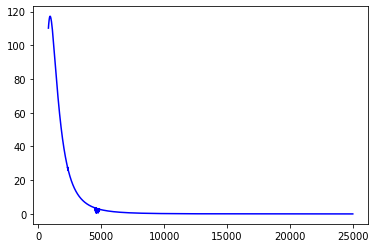

In [142]:
xs = []
ys = []
for key in spectrum:
    xs.append(float(key))
    ys.append(float(spectrum[key]))
plt.plot(np.array(xs), np.array(ys), 'blue')
print("The Spectrum after Step B")
plt.show()

## Step C: Transmission Spectrum of Windows/Beamsplitter
At this point in the program, the user input affects how the program is executed. For example, if the user inputed "AR_ZnSe" for the beamsplitter, then `__AR_ZnSe` will be excuted. If they input "AR_CaF2", then `__AR_CaF2` will be executed. The same holds true whenever there is an choice in steps C and D.

### The Beamsplitter


#### The `__AR_ZnSe` Function

In [143]:
def __AR_ZnSe(data):
    
    if data == None:
        return False

    for x in data:
        x_um = x / 1000
        datapoint = (0.82609) / ((1 + ((34.63971 / x_um) ** -8.56269)) ** 186.34792) + -0.47 / \
            (0.55* math.sqrt(math.pi / (4 * math.log(2)))) * math.exp(-4 * math.log(2) * ((x_um- 1.47) ** 2) / (0.55 ** 2)) + -0.03456 / \
                (0.4 * math.sqrt(math.pi / (4 * math.log(2)))) * math.exp(-4 * math.log(2) * ((x_um- 2.88) ** 2) / (0.4 ** 2)) + -0.009 / \
                    (0.3 * math.sqrt(math.pi / (4 * math.log(2)))) * math.exp(-4 * math.log(2) * ((x_um- 6.16) ** 2) / (0.3 ** 2)) + -0.09 / \
                        (1 * math.sqrt(math.pi / (4 * math.log(2)))) * math.exp(-4 * math.log(2) * ((x_um- 16.2) ** 2) / (1 ** 2)) + -0.08 / \
                            (1 * math.sqrt(math.pi / (4 * math.log(2)))) * math.exp(-4 * math.log(2) * ((x_um- 17.4) ** 2) / (1 ** 2)) + 1.12 / \
                                (8 * math.sqrt(math.pi /(4 * math.log(2)))) * math.exp(-4 * math.log(2) * ((x_um- 9.5) ** 2) / (8 ** 2)) + 0.11546 / \
                                    (2 * math.sqrt(math.pi / (4 * math.log(2)))) * math.exp(-4 * math.log(2) * ((x_um- 4.9) ** 2) / (2 ** 2)) + 0.21751 / \
                                        (2 * math.sqrt(math.pi / (4 * math.log(2)))) * math.exp(-4 * math.log(2) * ((x_um- 2.6) ** 2) / (2 ** 2)) + -0.05 / \
                                            (0.07 * math.sqrt(math.pi / (4 * math.log(2)))) * math.exp(-4 * math.log(2) * ((x_um- 0.8) ** 2) / (0.07 ** 2))

        data[x] = datapoint * data[x]

    return data

#### The `__AR_CaF2` Function

In [144]:
def __AR_CaF2(data):
  

    if data == None:
        return False

    for x in data:
        x_um = x / 1000
        datapoint = (0.9795) / ((1 + ((18.77617/ x_um) ** -6.94246) ) ** 91.98745) + -0.06 / (0.08 * math.sqrt(math.pi /(4 * math.log(2)))) * \
            math.exp(-4 * math.log(2) * (( x_um- 0.76) ** 2) / (0.08 ** 2))+-0.06 / (0.2 * math.sqrt(math.pi /(4 * math.log(2)))) * \
                math.exp(-4 * math.log(2) * ( x_um-1.06) ** 2/0.20 ** 2) + -0.6 / (3.0 * math.sqrt(math.pi /(4 * math.log(2)))) * \
                    math.exp(-4 * math.log(2) * (( x_um-4.85) ** 2) / (3.0 ** 2)) + -0.35 / (1.0 * math.sqrt(math.pi /(4 * math.log(2)))) * \
                        math.exp(-4 * math.log(2) * (( x_um- 9.40) ** 2) / (1.00 ** 2)) + 0.05 / (0.8 * math.sqrt(math.pi / (4 * math.log(2)))) * \
                            math.exp(-4 * math.log(2) * (( x_um- 2.60) ** 2) / (0.8 ** 2)) + 0.04 / (0.5 * math.sqrt(math.pi / (4 * math.log(2)))) * \
                                math.exp(-4 * math.log(2) * (( x_um- 7.75) ** 2) / (0.50 ** 2)) + -0.01 / (0.6 * math.sqrt(math.pi / (4 * math.log(2)))) * \
                                    math.exp(-4 * math.log(2) * (( x_um- 6.55) ** 2) / (0.6 ** 2)) + 0.01 / (0.5 * math.sqrt(math.pi /(4 * math.log(2)))) * \
                                        math.exp(-4 * math.log(2) * (( x_um- 1.82) ** 2) / (0.5 ** 2))
        data[x] = datapoint * data[x]
    
    return data

#### The Beamsplitter Functions in `process_spectrum`

In [145]:
# Beamsplitter
if beamsplitter == "AR_ZnSe":
    spectrum = __AR_ZnSe(spectrum)
elif beamsplitter == "AR_CaF2": 
    spectrum = __AR_CaF2(spectrum)

The Spectrum after Step C: Beamsplitter


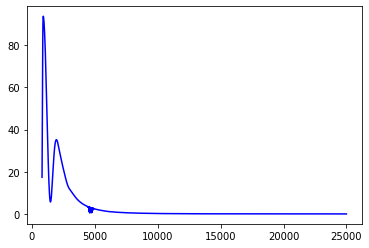

In [146]:
xs = []
ys = []
for key in spectrum:
    xs.append(float(key))
    ys.append(float(spectrum[key]))
plt.plot(np.array(xs), np.array(ys), 'blue')
print("The Spectrum after Step C: Beamsplitter")
plt.show()

### The Cell Windows

#### The `__CaF2` Function

In [148]:
def __CaF2(data):  

    if data == None:
        return False

    for x in data:
        datapoint = (0.93091) / (1 + (11.12929/ (x / 1000)) ** -12.43933 ) ** 4.32574
        data[x] = datapoint * data[x]
    
    return data

#### The `__ZnSe` Function

In [149]:
def __ZnSe(data):  

    if data == None:
        return False

    for x in data:
        x_um = x / 1000
        datapoint = (0.71015) / ((1 + (20.99353 / x_um) ** -19.31355 ) ** 1.44348) + -0.13265 / (2.25051 * math.sqrt(math.pi /(4 * math.log(2)))) * \
            math.exp(-4 * math.log(2) * ((x_um - 16.75) ** 2) / (2.25051 ** 2))
        data[x] = datapoint * data[x]

    return data

#### The Cell Window Functions in `process_spectrum`

In [150]:
# Cell Windows
if cell_window == "CaF2":
    spectrum = __CaF2(spectrum)
    spectrum = __CaF2(spectrum)
elif cell_window == "ZnSe":
    spectrum = __ZnSe(spectrum)
    spectrum = __ZnSe(spectrum)

The Spectrum after Step C: Cell Windows


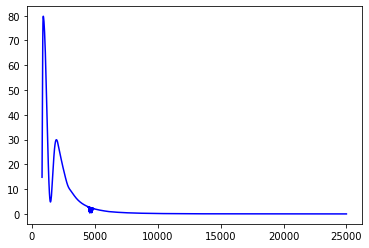

In [151]:
xs = []
ys = []
for key in spectrum:
    xs.append(float(key))
    ys.append(float(spectrum[key]))
plt.plot(np.array(xs), np.array(ys), 'blue')
print("The Spectrum after Step C: Cell Windows")
plt.show()

## Step D: Detector Response Spectrum

### The `__sapphire` Function

In [152]:
def __sapphire(data): 

    if data == None:
        return False

    for x in data:
        # Gets accurate graph with numpy float128 but throws runtime overflow error
        # datapoint = Decimal(0.78928) / Decimal(1 + (11.9544 / (x / 1000)) ** -12.07226 ) ** (Decimal(6903.57039))
        datapoint = np.float128(0.78928) / np.float128(1 + (11.9544 / (x / 1000)) ** -12.07226 ) ** (np.float128(6903.57039))
        data[x] = datapoint * np.float128(data[x])
    
    return data

### The Detector

#### The `__MCT` Function

In [155]:
def __MCT(data):  

    if data == None:
        return False

    for x in data:
        x_um = x / 1000
        datapoint = (1.98748 * (10 ** 9)) + (2.10252 * (10 ** 10)) * (1 / (1 + math.exp( -(x_um - 20.15819) / 5.73688))) * \
            (1 - 1 / (1 + math.exp( -(x_um - 20.15819) / 1.11659))) + (1.3 * (10 ** 9)) / (2 * math.sqrt(math.pi / (4 * math.log(2)))) * \
                math.exp(-4 * math.log(2) * ((x_um - 18.6) ** 2) / (2 ** 2))
        data[x] = datapoint * data[x]
   
    return data

#### The `__InSb` Function

In [156]:
def __InSb(data):

    if data == None:
        return False

    for x in data:
        x_um = x /1000
        datapoint = 1.97163E11 * (1 / (1 + math.exp( -(x_um- 5.3939) / 1.6624))) * (1 - 1 / (1 + math.exp( -(x_um- 5.3939) / 0.11925))) + \
            (3.3e10) / (2.44977 * math.sqrt(math.pi / (4 * math.log(2)))) * math.exp(-4 * math.log(2) * ((x_um- 5) ** 2) / (2.44977 ** 2))
        data[x] = datapoint * data[x]
    
    return data

### The Step D Function in `process_spectrum`

In [157]:
# ----- d.) detector response spectrum -----


if detector == "MCT":
    spectrum = __ZnSe(spectrum)
    spectrum = __MCT(spectrum)
elif detector == "InSb":
    spectrum = __sapphire(spectrum)
    spectrum = __InSb(spectrum)

The Spectrum after Step D: Detector


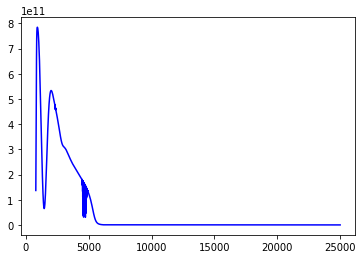

In [158]:
xs = []
ys = []
for key in spectrum:
    xs.append(float(key))
    ys.append(float(spectrum[key]))
plt.plot(np.array(xs), np.array(ys), 'blue')
print("The Spectrum after Step D: Detector")
plt.show()

## Exporting the Final Result
All of our calcualtions are complete! Now, the `__exportData` function is called to translate our data into a `.ssv`, or Space SPearated File.

In [159]:
__exportData(spectrum, 'calc_spectrum-%s-%s-processed'%(min_wavelen, max_wavelen))

True

Now we can graph our final results! Click `Run All` to see the result of each step!

The Final Results


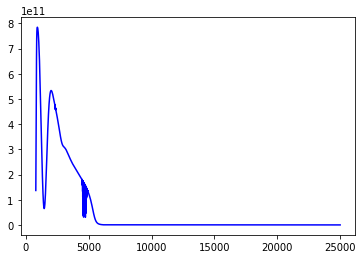

In [160]:
xs = []
ys = []
for key in spectrum:
    xs.append(float(key))
    ys.append(float(spectrum[key]))
plt.plot(np.array(xs), np.array(ys), 'blue')
print("The Final Results")
plt.show()